In [84]:
#!/usr/bin/env python
# coding: utf-8

# Este notebook realiza a preparação dos dados e treina um modelo LSTM para prever o valor unitário de um produto.
# Ajuste os caminhos dos arquivos conforme necessário.

# In[1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Configurações de plot
plt.style.use('seaborn-v0_8-darkgrid')

In [85]:
# In[2]:
# Caminhos dos arquivos
DATA_PATH = '../data'  # Ajuste conforme sua estrutura
DATA_FILE = 'dados_transacao_26173.csv' # Ajuste o nome do seu arquivo CSV

full_path = os.path.join(DATA_PATH, DATA_FILE)

df = pd.read_csv(full_path, sep=',', decimal='.', parse_dates=['Data'], dayfirst=True)

# Observando rapidamente o dataframe
print(df.head())
print(df.info())

   CodigoVenda        Data             DataHora Status  VendaCancelada  \
0      2263035  2019-01-02  2019-01-02 08:36:25      f               0   
1      2263063  2019-01-02  2019-01-02 09:01:27      f               0   
2      2263067  2019-01-02  2019-01-02 09:06:07      f               0   
3      2263151  2019-01-02  2019-01-02 09:55:52      f               0   
4      2263159  2019-01-02  2019-01-02 10:01:20      f               0   

   TotalPedido  DescontoGeral  AcrescimoGeral  TotalCusto  CodigoProduto  ...  \
0        58.08            0.0             0.0       27.30          26173  ...   
1        40.05            0.0             0.0       29.45          26173  ...   
2        34.75            0.0             0.0       26.94          26173  ...   
3       210.10            0.0             0.0      146.63          26173  ...   
4        96.72            0.0             0.0       60.43          26173  ...   

   ValorCustoGerencial  CodigoFornecedor  CodigoKitPrincipal  \
0   

In [86]:
# In[3]:
# Vamos agrupar por data, obtendo o valor médio diário.
# A coluna 'ValorUnitario' existe no dataset original.
# Caso a coluna tenha outro nome (ex: ValorUnitario), ajuste abaixo.

# Caso o seu CSV tenha o nome da coluna ValorUnitario diferente, ajuste aqui.
col_valor = 'ValorUnitario'
col_data = 'Data'

daily = df.groupby(col_data)[col_valor].mean().to_frame(name='valor_medio_diario')

# Converter o índice para datetime, caso ainda não seja
daily.index = pd.to_datetime(daily.index)

print(daily.head())
print(daily.tail())

            valor_medio_diario
Data                          
2019-01-02            1.978571
2019-01-03            1.978333
2019-01-04            1.981918
2019-01-05            1.981000
2019-01-06            1.982542
            valor_medio_diario
Data                          
2024-08-23            3.515862
2024-08-24            3.534545
2024-08-25            3.545000
2024-08-26            3.545625
2024-08-27            3.542222


In [87]:
# In[4]:
# Vamos criar um índice diário contínuo de 01/01/2019 até 27/08/2024 (ou até o último dia existente no dataset)
data_inicial = daily.index.min()
data_final = daily.index.max()

full_range = pd.date_range(start=data_inicial, end=data_final, freq='D')
daily = daily.reindex(full_range)

# Preencher valores ausentes com o último valor conhecido
daily = daily.ffill()

print(daily.isna().sum())
print(daily.head())
print(daily.tail())

valor_medio_diario    0
dtype: int64
            valor_medio_diario
2019-01-02            1.978571
2019-01-03            1.978333
2019-01-04            1.981918
2019-01-05            1.981000
2019-01-06            1.982542
            valor_medio_diario
2024-08-23            3.515862
2024-08-24            3.534545
2024-08-25            3.545000
2024-08-26            3.545625
2024-08-27            3.542222


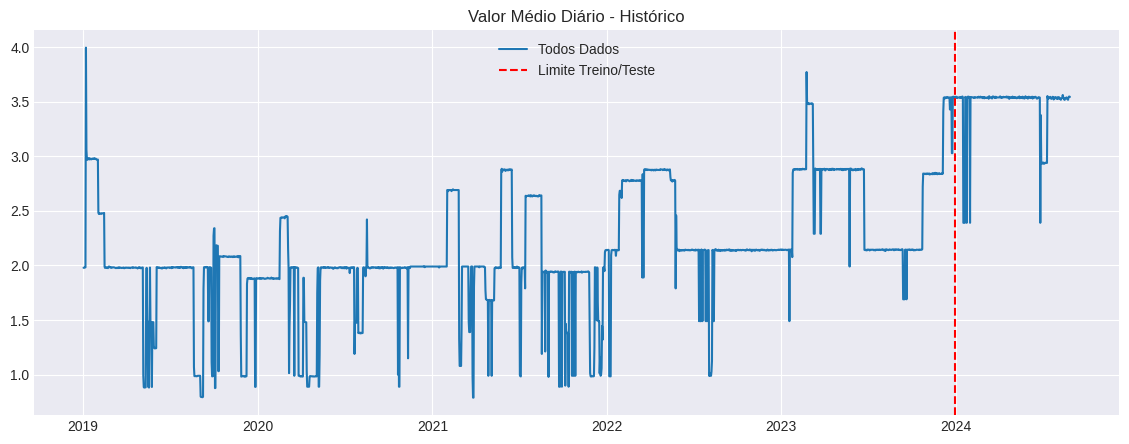

In [88]:
# In[5]:
# Agora vamos separar treino e teste
# Treino: 01/01/2019 a 31/12/2023
# Teste: 01/01/2024 a 30/03/2024

train_end_date = datetime(2023, 12, 31)
test_end_date = datetime(2024, 3, 30)

train_data = daily.loc[:train_end_date]
test_data = daily.loc[datetime(2024,1,1):test_end_date]

# Visualização dos dados de treino e teste
plt.figure(figsize=(14,5))
plt.plot(daily.index, daily['valor_medio_diario'], label='Todos Dados')
plt.axvline(x=train_end_date, color='red', linestyle='--', label='Limite Treino/Teste')
plt.title('Valor Médio Diário - Histórico')
plt.legend()
plt.show()

In [89]:
# In[6]:
# Normalização dos dados para uso no LSTM
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)

# Função para criar janelas de tempo (X, y)
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lookback = 30
X_train, y_train = create_sequences(train_scaled, lookback=lookback)
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)

# Para o teste, precisamos concatenar os últimos 30 dias de 2023 com o teste para termos contexto
# Mas como queremos prever a partir de 2024-01-01, precisamos ter os valores anteriores.

# Pegar os últimos 30 dias do treino para "inicializar" o teste
last_days_train = train_data[-lookback:]
test_full = pd.concat([last_days_train, test_data], axis=0)
test_scaled = scaler.transform(test_full)

X_test, y_test = create_sequences(test_scaled, lookback=lookback)

# Verificar NaNs
print("NaNs em X_train:", np.isnan(X_train).any())
print("NaNs em y_train:", np.isnan(y_train).any())
print("NaNs em X_test:", np.isnan(X_test).any())
print("NaNs em y_test:", np.isnan(y_test).any())

print("Shape X_test:", X_test.shape)
print("Shape y_test:", y_test.shape)

# Note que y_test agora é o valor previsto a partir da primeira data após as 30 janelas finais do treino.

Shape X_train: (1795, 30, 1)
Shape y_train: (1795, 1)
NaNs em X_train: False
NaNs em y_train: False
NaNs em X_test: False
NaNs em y_test: False
Shape X_test: (90, 30, 1)
Shape y_test: (90, 1)


In [ ]:
# In[7]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.1))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(64))
model.add(Dropout(0.1))

model.add(Dense(1))

# Ajustar o otimizador, por exemplo Adam com taxa de aprendizado menor
optimizer = Adam(learning_rate=0.0005)

# Testar função de perda 'mae', pode ser trocada para 'mse' caso desejado
model.compile(optimizer=optimizer, loss='mae')

model.summary()

/home/jociano/Projects/PromoPredictor/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 30, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,785 (1.95 MB)

 Trainable params: 510,785 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# In[8]:
# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/200


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4300 - val_loss: 0.1967
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3076 - val_loss: 0.1357
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2889 - val_loss: 0.1453
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2602 - val_loss: 0.1393
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2354 - val_loss: 0.1130
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2176 - val_loss: 0.1089
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1926 - val_loss: 0.1110
Epoch 8/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1789 - val_loss: 0.0943
Epoch 9/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1948 - val_loss: 0.0931
Epoch 10/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1636 - val_loss: 0.1024
Epoch 11/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1645 - val_loss: 0.0792
Epoch 12/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1714 - val_l

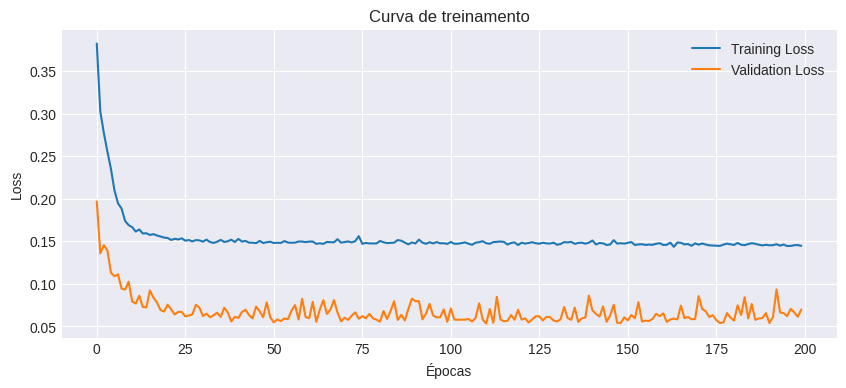

In [92]:
# In[9]:
# Visualização da curva de loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
# In[10]:
# Previsões no período de teste
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# O y_test também está em escala transformada, vamos revertê-lo
y_test_original = scaler.inverse_transform(y_test)

# Ajustar o indice de y_true e y_pred para compararmos
test_dates = test_data.index[lookback:]  # datas correspondentes às previsões geradas

# Certifique-se que o comprimento de test_dates, y_test_original e y_pred é o mesmo
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
print("y_pred.shape:", y_pred.shape)
print("test_data.shape:", test_data.shape)

test_dates = test_data.index
print("Len test_dates:", len(test_dates))
print("Len y_test_original:", len(y_test_original))
print("Len y_pred:", len(y_pred))

# Caso haja discrepância no tamanho, verifique se test_data tem o mesmo número de dias que y_test
# Já que criamos as sequências, o y_test terá length = len(test_full) - lookback
# E test_full = 30 (lookback) + len(test_data)
# Então, len(y_test) = len(test_data)
# Logo, devem ser iguais.
df_pred = pd.DataFrame({'Data': test_dates, 'Valor Real': y_test_original.flatten(), 'Predição': y_pred.flatten()})

df_pred.set_index('Data', inplace=True)

print(df_pred.head(100))

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
X_test.shape: (90, 30, 1)
y_test.shape: (90, 1)
y_pred.shape: (90, 1)
test_data.shape: (90, 1)
Len test_dates: 90
Len y_test_original: 90
Len y_pred: 90
            Valor Real  Predição
Data                            
2024-01-01    3.541111  3.486233
2024-01-02    3.544868  3.485693
2024-01-03    3.532600  3.488909
2024-01-04    3.537759  3.477847
2024-01-05    3.534815  3.482056
...                ...       ...
2024-03-26    3.534762  3.484350
2024-03-27    3.536538  3.477272
2024-03-28    3.537727  3.478348
2024-03-29    3.537727  3.479909
2024-03-30    3.538143  3.479448

[90 rows x 2 columns]


In [94]:
# In[11]:
# Métricas de avaliação
mae = mean_absolute_error(df_pred['Valor Real'], df_pred['Predição'])
mse = mean_squared_error(df_pred['Valor Real'], df_pred['Predição'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.1370
RMSE: 0.3090


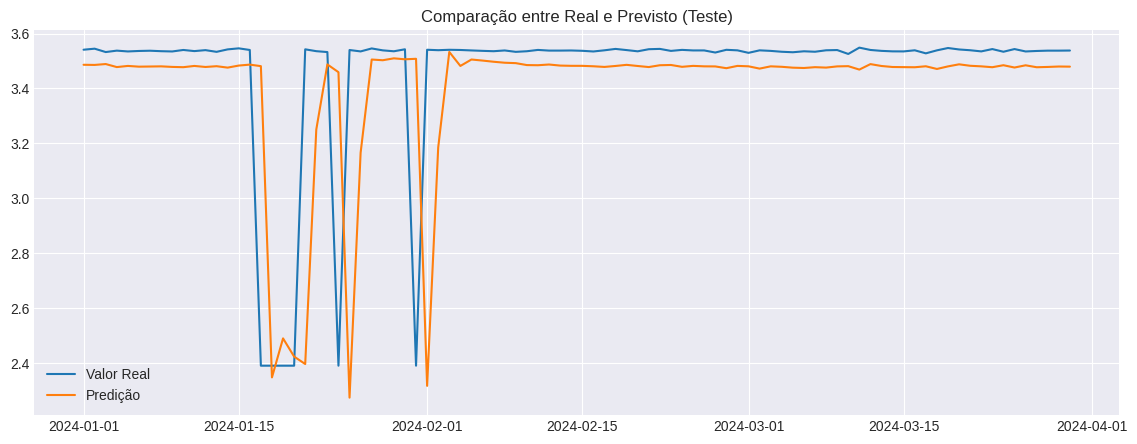

In [95]:
# In[12]:
# Visualização da comparação
plt.figure(figsize=(14,5))
plt.plot(df_pred.index, df_pred['Valor Real'], label='Valor Real')
plt.plot(df_pred.index, df_pred['Predição'], label='Predição')
plt.title('Comparação entre Real e Previsto (Teste)')
plt.legend()
plt.show()

In [96]:
# In[13]:
# Caso queira prever dias futuros (além de 30/03/2024), pode-se fazer a previsão iterativa.
# Mas como estamos apenas avaliando o período de teste, já finalizamos aqui.

# Observações e melhorias:
# - Ajuste do número de épocas, tamanho da janela, arquitetura da rede.
# - Testar outros modelos (Prophet, ARIMA, XGBoost) para comparar resultados.
# - Ajustar semente random para reprodutibilidade.